In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, XGBRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score

%pylab inline
data=None
def absolute_correlations(col, df=data):
    #absolute_values = np.abs(df[col])
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs.sort_values('absol', ascending=False).drop('absol', axis=1).tail(len(corrs)-1)

def numeric(self):
    '''Monkey-patches numeric features'''
    return self.select_dtypes(include=[np.number])
pd.DataFrame.numeric = numeric

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('data_cleaned.csv')
for i in data.columns:
    if 'Unn' in i: del data[i]
country = data.pop('country')
# Take the good data
data = data[data['i_have_answered_all_of_these_questions_as_accurately_as_possible'] == 7]
data = data[data['i_understand_the_instructions_for_this_test'] == 7]

In [3]:
# Transpose the dataframe, so we're analyzing questions instead of users
qs = data.select_dtypes(include=[np.number]).fillna(data.mean()).T

qs['stdev'] = qs.std(axis=1)

questions_sorted = qs.sort_values('stdev', ascending=False)['stdev'].index

# Most controversial at top; least controversial at bottom
# questions_sorted

In [6]:
from collections import defaultdict

def absolute_correlations(col, df=data, threshold=.5):
    '''Finds related questions, with both positive and negative correlations'''
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs[corrs.absol > threshold].sort_values('absol', ascending=False).drop('absol', axis=1)

def rev(item):
    '''Questions are scored out of 7, and many need to be reverse-scored'''
    return 8 - item

In [81]:
# Record which questions go in each factor
factors = defaultdict(list)

# Use each question only once
questions_used = []

# Put users' scores in a dataframe
df_factors = pd.DataFrame()

for question in questions_sorted:
    if question not in questions_used:
        related = absolute_correlations(
            question,
            df=data[[i for i in data.columns if i not in questions_used]],
            threshold=.5
        )        
        if len(related) >= 4:
            for related_question in related.index:
                questions_used.append(related_question)
            factors[question].append(related.index)
            
            pos_items = related[related['correlation'] > 0].index
            neg_items = related[related['correlation'] < 0].index
            all_items = list(pos_items) + list(neg_items)   

            df_factors[question] = (data[pos_items].sum(axis=1) + (8-data[neg_items]).sum(axis=1))/(.07*len(all_items))
            
print('found', str(df_factors.shape[1]), 'personality traits')

found 16 personality traits


In [82]:
df_factors

,i_dont_talk_a_lot,i_seem_to_derive_less_enjoyment_from_interacting_with_people_than_others_do,i_find_that_it_takes_a_lot_to_make_me_feel_angry_at_someone,i_am_a_physical_coward,i_am_just_an_ordinary_person,i_would_never_take_things_that_arent_mine,i_dont_mind_being_the_center_of_attention,i_often_forget_to_put_things_back_in_their_proper_place,i_get_stressed_out_easily,i_find_it_hard_to_forgive_others,i_put_on_a_show_to_impress_people,i_am_usually_active_and_full_of_energy,i_make_rash_decisions,i_continue_until_everything_is_perfect,i_work_hard,i_come_up_with_something_new
1,59.183673,71.428571,62.500000,57.142857,21.428571,42.857143,78.571429,67.857143,71.428571,82.142857,78.571429,50.000000,53.571429,71.428571,32.142857,85.714286
3,63.265306,57.142857,35.714286,82.142857,39.285714,46.428571,60.714286,71.428571,85.714286,53.571429,67.857143,42.857143,75.000000,64.285714,42.857143,60.714286
5,61.224490,63.265306,37.500000,57.142857,82.142857,46.428571,21.428571,100.000000,88.095238,60.714286,85.714286,21.428571,71.428571,57.142857,42.857143,82.142857
6,14.285714,18.367347,42.857143,53.571429,53.571429,92.857143,100.000000,60.714286,80.952381,46.428571,78.571429,67.857143,92.857143,57.142857,67.857143,60.714286
8,59.183673,71.428571,60.714286,67.857143,71.428571,92.857143,50.000000,32.142857,35.714286,89.285714,42.857143,35.714286,32.142857,71.428571,67.857143,85.714286
9,32.653061,48.979592,41.071429,39.285714,60.714286,89.285714,82.142857,46.428571,64.285714,57.142857,57.142857,78.571429,75.000000,71.428571,60.714286,71.428571
16,22.448980,46.938776,48.214286,46.428571,17.857143,82.142857,50.000000,39.285714,54.761905,42.857143,32.142857,25.000000,50.000000,46.428571,28.571429,89.285714
22,42.857143,61.224490,28.571429,75.000000,67.857143,75.000000,89.285714,89.285714,59.523810,25.000000,50.000000,32.142857,85.714286,42.857143,25.000000,75.000000
24,59.183673,75.510204,60.714286,92.857143,60.714286,96.428571,39.285714,89.285714,97.619048,46.428571,46.428571,25.000000,28.571429,60.714286,32.142857,67.857143
27,30.612245,28.571429,26.785714,60.714286,50.000000,32.142857,71.428571,85.714286,66.666667,53.571429,67.857143,42.857143,85.714286,39.285714,25.000000,71.428571


In [69]:
from sklearn.decomposition import FactorAnalysis

for n in range(50,2,-1):
    data = data.select_dtypes(include=[np.number])
    factor = FactorAnalysis(n_components=n, random_state=1).fit(data)

    # Stick it in a dataframe
    factors = pd.DataFrame(factor.components_, columns=data.columns).T

    col_names = []
    for i in range(n):
        # We'll need non-zero factor values for our next
        # step, so we'll start counting at 1
        col_names.append('factor_' + str(i + 1))

    factors.columns = col_names

    data_new = pd.DataFrame()
    items = []
    for i in col_names:
        for k, v in zip(factors[i].index, factors[i]):
            if np.abs(v) > 0.2: # factor loading
                items.append((i,k,v))
    
    # This effectively counts the number of items in
    # each factor. 4 or more should make the factor reliable. 
    items = pd.DataFrame(items)
    group = items.groupby(0).count()
    if len(group[group >= 4].dropna()) == n:
        print(n, 'works!')
        break

# OFA

In [7]:
def uncorrelated(col, df=data, threshold=100):
    '''Similar to absolute_correlations, but now finds uncorrelated items'''
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    
    # Default is to return all items sorted by correlation (ascending)
    return corrs[corrs.absol < threshold].sort_values('absol', ascending=True).drop('absol', axis=1)

In [8]:
from collections import defaultdict

# Record which questions go in each factor
factors = defaultdict(list)

# We're no longer going to worry if a question has been used
# We're now more interested in validity and reliability than style!
questions_used = []

# Put users' scores in a dataframe
df_factors = pd.DataFrame()

th = 0.55
lenrel = 4

# Seed the dataframe with the first reliable trait
for question in questions_sorted:
    related = absolute_correlations(
        question,
        df=data,
        threshold=th
    )        
    if len(related) >= lenrel:
        #for related_question in related.index:
            #questions_used.append(related_question)
        factors[question].append(related.index)

        pos_items = related[related['correlation'] > 0].index
        neg_items = related[related['correlation'] < 0].index
        all_items = list(pos_items) + list(neg_items)   

        df_factors[question] = (data[pos_items].sum(axis=1) + (8-data[neg_items]).sum(axis=1))/(.07*len(all_items))
        break

# So far, so good
df_factors.head()

,i_dont_talk_a_lot
1,61.904762
3,64.285714
5,61.904762
6,14.285714
8,59.523810


In [9]:
corr = 0

# Run this until we find a trait that correlates more than 0.7 with an existing one
while corr < .50:
    next_q = data.corrwith(df_factors[df_factors.columns[-1]])
    candidates = pd.DataFrame()
    for i in np.abs(next_q).sort_values().index:
        related = absolute_correlations(
            i,
            df=data,
            threshold=th)        
        if len(related) >= lenrel:
            #for related_question in related.index:
                #questions_used.append(related_question)

            pos_items = related[related['correlation'] > 0].index
            neg_items = related[related['correlation'] < 0].index
            all_items = list(pos_items) + list(neg_items)
            candidates[i] = (data[pos_items].sum(axis=1) + (8-data[neg_items]).sum(axis=1))/(.07*len(all_items))

    candidates_scores = {}
    for i in candidates.columns:
        candidates_scores[i] = np.abs(df_factors.corrwith(candidates[i])).max()

    candidates_scores = pd.DataFrame([candidates_scores]).T.sort_values(0)

    print('Using:', pd.DataFrame(candidates_scores).index[0])
    
    corr = candidates_scores.get_value(candidates_scores.index[0], 0)
    print(round(corr, 2))
    
    next_q = data.corrwith(df_factors[df_factors.columns[-1]])
    candidates = pd.DataFrame()
    for i in candidates_scores.index:
        related = absolute_correlations(
            i,
            df=data, threshold=th)        
        if len(related) >= lenrel:
            #for related_question in related.index:
                #questions_used.append(related_question)
            factors[i].append(related.index)

            pos_items = related[related['correlation'] > 0].index
            neg_items = related[related['correlation'] < 0].index
            all_items = list(pos_items) + list(neg_items)
            df_factors[i] = (data[pos_items].sum(axis=1) + (8-data[neg_items]).sum(axis=1))/(.07*len(all_items))    
            break
    if i == candidates_scores.index[-1]:
        raise Exception('Could not find any more traits')
    
    print()

Using: i_find_it_hard_to_forgive_others
0.05

Using: i_leave_a_mess_in_my_room
0.07

Using: i_begin_to_panic_when_there_is_danger
0.17

Using: i_come_up_with_something_new
0.28

Using: i_get_irritated_easily
0.5

Using: i_rarely_enjoy_being_with_people
0.53



In [10]:
for num, top in enumerate(factors):
    print(str(num+1)+'. ' + top)
    for list_ in factors[top]:
        for question in list_:
            print('-', question)
    print()

1. i_dont_talk_a_lot
- i_dont_talk_a_lot
- i_say_little
- i_talk_a_lot
- i_speak_softly
- i_keep_in_the_background
- i_have_little_to_say

2. i_find_it_hard_to_forgive_others
- i_find_it_hard_to_forgive_others
- i_am_inclined_to_forgive_others
- i_hold_a_grudge
- i_try_to_forgive_and_forget

3. i_leave_a_mess_in_my_room
- i_leave_a_mess_in_my_room
- i_keep_things_tidy
- i_often_forget_to_put_things_back_in_their_proper_place
- i_leave_my_belongings_around

4. i_begin_to_panic_when_there_is_danger
- i_begin_to_panic_when_there_is_danger
- i_panic_easily
- i_tremble_in_dangerous_situations
- i_face_danger_confidently
- i_remain_calm_under_pressure

5. i_come_up_with_something_new
- i_come_up_with_something_new
- i_am_full_of_ideas
- i_have_excellent_ideas
- i_love_to_think_up_new_ways_of_doing_things

6. i_get_irritated_easily
- i_get_irritated_easily
- i_am_easily_annoyed
- i_get_angry_easily
- i_rarely_get_irritated
- i_rarely_feel_angry_with_people
- i_lose_my_temper
- i_seldom_get_ma

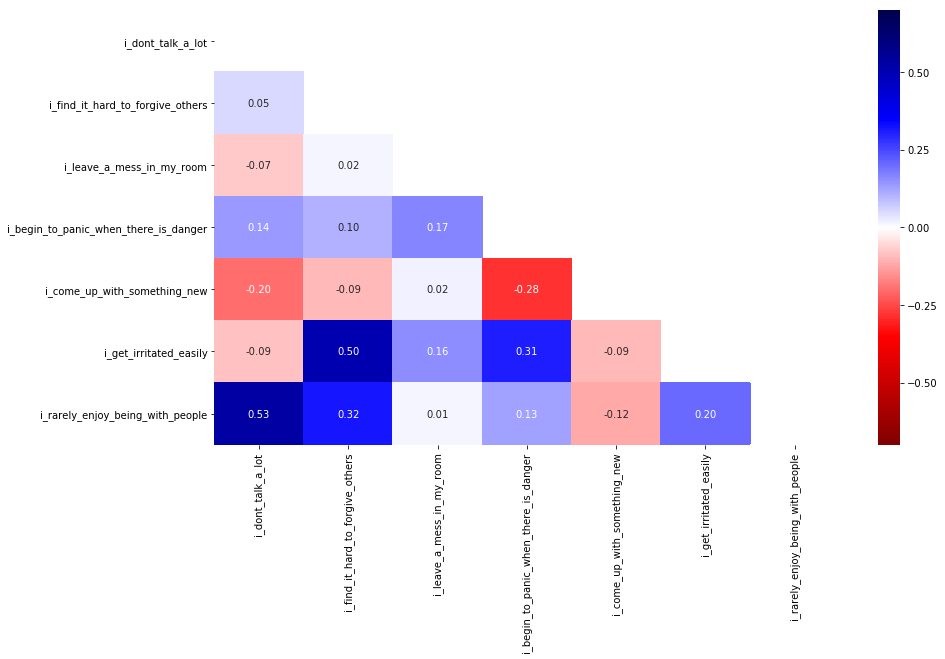

In [12]:
# Generate a mask for the upper triangle
mask = np.zeros_like(df_factors.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Resize and display
plt.figure(figsize=(14,8))
sns.heatmap(df_factors.corr(), annot=True, 
            vmax=.7, vmin=-.7, fmt='.2f', mask=mask, cmap='seismic_r')

In [15]:
df_factors['country'] = country

In [17]:
df_factors.groupby('country').mean().sort_values('i_find_it_hard_to_forgive_others')

,i_dont_talk_a_lot,i_find_it_hard_to_forgive_others,i_leave_a_mess_in_my_room,i_begin_to_panic_when_there_is_danger,i_come_up_with_something_new,i_get_irritated_easily,i_rarely_enjoy_being_with_people
country,,,,,,,
IR,52.380952,21.428571,57.142857,37.142857,100.000000,33.333333,17.142857
IQ,70.238095,23.214286,60.714286,44.285714,58.928571,87.301587,28.571429
TN,45.238095,25.000000,85.714286,41.428571,87.500000,42.063492,31.428571
AX,47.619048,25.000000,82.142857,71.428571,71.428571,41.269841,34.285714
GE,80.952381,28.571429,92.857143,17.142857,96.428571,50.793651,40.000000
A1,52.380952,28.571429,83.035714,46.428571,73.214286,54.365079,77.142857
UA,70.634921,29.761905,61.904762,31.428571,70.238095,33.333333,52.380952
LY,47.619048,32.142857,96.428571,31.428571,100.000000,53.968254,37.142857
LB,56.666667,34.285714,59.285714,41.142857,91.428571,58.412698,49.142857


In [18]:
factors

defaultdict(list,
            {'i_begin_to_panic_when_there_is_danger': [Index(['i_begin_to_panic_when_there_is_danger', 'i_panic_easily',
                     'i_tremble_in_dangerous_situations', 'i_face_danger_confidently',
                     'i_remain_calm_under_pressure'],
                    dtype='object')],
             'i_come_up_with_something_new': [Index(['i_come_up_with_something_new', 'i_am_full_of_ideas',
                     'i_have_excellent_ideas',
                     'i_love_to_think_up_new_ways_of_doing_things'],
                    dtype='object')],
             'i_dont_talk_a_lot': [Index(['i_dont_talk_a_lot', 'i_say_little', 'i_talk_a_lot', 'i_speak_softly',
                     'i_keep_in_the_background', 'i_have_little_to_say'],
                    dtype='object')],
             'i_find_it_hard_to_forgive_others': [Index(['i_find_it_hard_to_forgive_others', 'i_am_inclined_to_forgive_others',
                     'i_hold_a_grudge', 'i_try_to_forgive_and_forget